In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
# from scipy.misc import imread
import codecs
from IPython.display import HTML

movies = pd.read_csv('../dataset/tmdb_5000_movies.csv')
credits = pd.read_csv('../dataset/tmdb_5000_credits.csv')

movies.head(3)
#credits.head(3)

# Possible features: keywords, popularity, production_countries,
# revenue, vote_count


# Clean the dataset by converting json columns into list of strings
fields = ['genres', 'keywords', 'production_companies', 'production_countries']
for field in fields:
    movies[field]=movies[field].apply(json.loads)
    for index,i in zip(movies.index,movies[field]):
        list1=[]
        for j in range(len(i)):
            list1.append((i[j]['name']))
        movies.loc[index,field]=str(list1)
        
        
# Clean the credits 
credits['cast']=credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1=[]
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast']=str(list1)

fields = ['crew']
for field in fields:
    credits[field] = credits[field].apply(json.loads)
    def director(x):
        for i in x:
            if i['job'] == 'Director':
                return i['name']
    credits['crew'] = credits['crew'].apply(director)
    credits.rename(columns={'crew':'director'},inplace=True)

In [3]:
# Need to combine two datasets. Can join on movie_id
df = pd.merge(movies, credits, how='left', left_on='id', right_on='movie_id')

In [4]:
# Feature engineering! select which ones we want here...
features = ['id', 'original_title', 'genres', 'cast', 'vote_average', 'director', 'keywords', 'popularity', 'vote_count']
df = df[features]

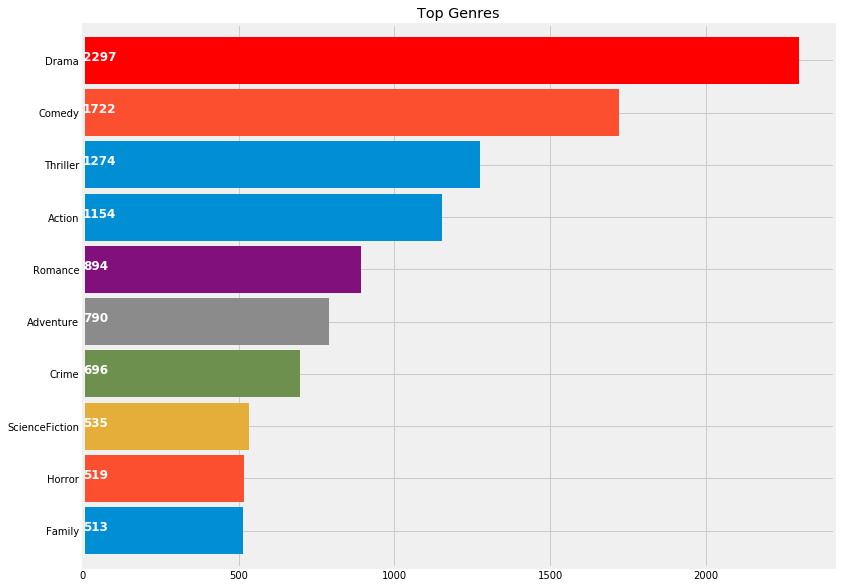

In [5]:
# Find top genres
df['genres'] = df['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('Adventure', 'Adv').str.replace('u', '').str.replace('Adv', 'Adventure')
df['genres'] = df['genres'].str.split(',')


# Code for plotting from here: https://www.kaggle.com/ash316/what-s-my-score/notebook

plt.subplots(figsize=(12,10))
list1=[]
for i in df['genres']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9)
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
ax.patches[9].set_facecolor('r')
plt.title('Top Genres')
plt.show()

In [6]:
# Create an ordered list of all possible genres so we can use a bit string to represent them
genreList = []
for genres in df['genres']:
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
            
genreList.sort()
genreList = genreList[1:]
print(genreList)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Msic', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western']


In [7]:
# Create the bitstring of genres
def genre_bitlist(genres):
    blist = []
    for genre in genreList:
        if genre in genres:
            blist.append(1)
        else:
            blist.append(0)
    return blist

            
df['genres_bs'] = df['genres'].apply(lambda x: genre_bitlist(x))

In [8]:
# Work with cast. Let's get the top 25 actors
n = 25

df['cast']=df['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df['cast']=df['cast'].str.split(',')


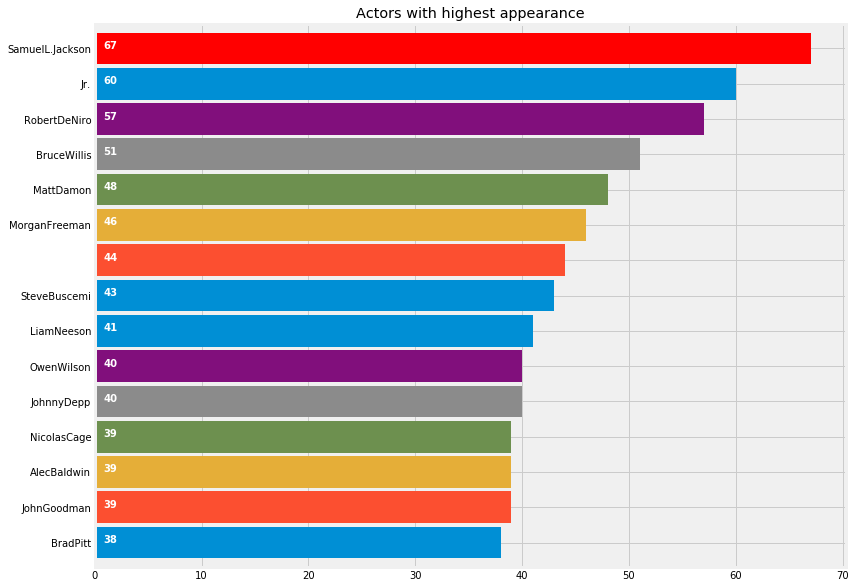

In [9]:
plt.subplots(figsize=(12,10))
list1=[]
for i in df['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9)
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
ax.patches[14].set_facecolor('r')
plt.show()

In [10]:
import operator 
actorList = []
list1 = []
for i in df['cast']:
    list1.extend(i)
    
actors = {}
for actor in list1:
    if actor in actors:
        actors[actor] += 1
    else:
        actors[actor] = 1
        
sorted_actors = sorted(actors.items(), key=operator.itemgetter(1))

for i in range(0, 21):
    actorList.append(sorted_actors[-1-i])
    

actorList = [actor[0] for actor in actorList]
alist = []
for actor in actorList:
    if actor != 'r.': # Get rid of this trailing value
        alist.append(actor)
actorList = alist

# Now we need to sort the list!
actorList = sorted(actorList)
actorList = actorList[1:]

In [11]:
# Create the bitstring of genres
def actor_bitlist(actors):
    blist = []
    for actor in actorList:
        if actor in actors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['cast_bs'] = df['cast'].apply(lambda x: actor_bitlist(x))

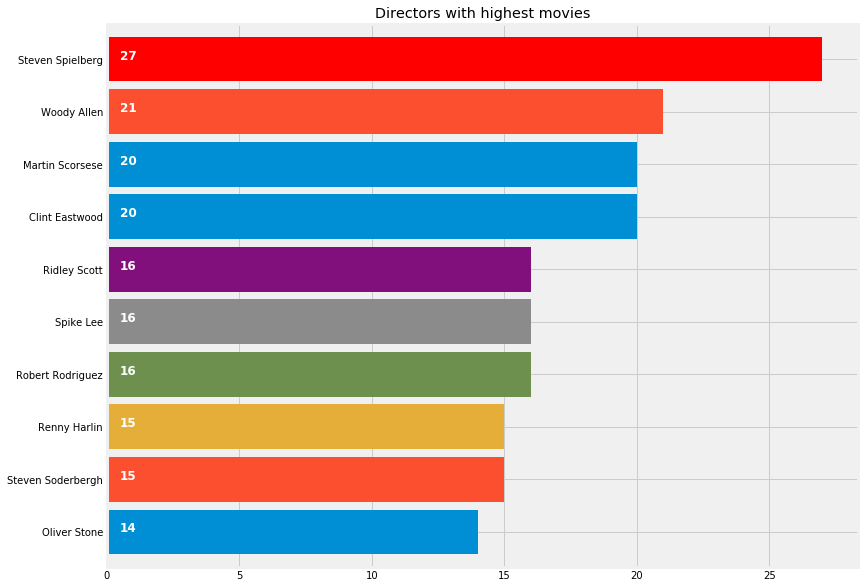

In [12]:
# Now directors
def isnull(s):
    if s is None:
        return ''
    return s

df['director'] = df['director'].apply(isnull)


plt.subplots(figsize=(12,10))
ax=df[df['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.85)
for i, v in enumerate(df[df['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
ax.patches[9].set_facecolor('r')
plt.title('Directors with highest movies')
plt.show()

In [13]:
directorList = []
for director in df['director']:
    if director not in directorList:
        directorList.append(director)
        
directorList = sorted(directorList)[1:]

In [14]:
def director_bitlist(directors):
    blist = []
    for director in directorList:
        if director in directors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['director_bs'] = df['director'].apply(lambda x: director_bitlist(x))

In [15]:
# Allows us to make each genre a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for g in genreList:
    for index, row in df.iterrows():
        genres = row["genres"]
        if g in genres:
            cols[g].append(1)
        else:
            cols[g].append(0)
        
    df[g] = cols[g]
    

In [16]:
# Allows us to make each actor a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for a in actorList:
    for index, row in df.iterrows():
        cast = row["cast"]
        if a in cast:
            cols[a].append(1)
        else:
            cols[a].append(0)
        
    df[a] = cols[a]

In [17]:
lin_features = ['popularity',  'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Msic', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western', 'uAlecBaldwin', 'uBradPitt', 'uBruceWillis', 'uJimBroadbent', 'uJohnGoodman', 'uJohnnyDepp', 'uLiamNeeson', 'uMattDamon', 'uMorganFreeman', 'uNicolasCage', 'uOwenWilson', 'uPaulGiamatti', 'uRichardJenkins', 'uRobertDeNiro', 'uSamuelL.Jackson', 'uStanleyTucci', 'uSteveBuscemi', 'uWillFerrell', 'uWillemDafoe']
target = ['vote_average']

from sklearn import linear_model
from sklearn.model_selection import cross_validate

X = df[lin_features]
Y = df[target]

lin = linear_model.LinearRegression()


# Don't specify scoring/loss function so that it will default to 
# linear regression's default of sum of residual squares (what we want)
cv_results = cross_validate(lin, X, Y, cv=10)

KeyError: "['uAlecBaldwin' 'uBradPitt' 'uBruceWillis' 'uJimBroadbent' 'uJohnGoodman'\n 'uJohnnyDepp' 'uLiamNeeson' 'uMattDamon' 'uMorganFreeman' 'uNicolasCage'\n 'uOwenWilson' 'uPaulGiamatti' 'uRichardJenkins' 'uRobertDeNiro'\n 'uSamuelL.Jackson' 'uStanleyTucci' 'uSteveBuscemi' 'uWillFerrell'\n 'uWillemDafoe'] not in index"

In [ ]:
test_score = cv_results['test_score']
train_score = cv_results['train_score']

print(test_score)
print(train_score)

print("Mean test score: ", reduce(lambda x, y: abs(x)+abs(y), test_score)/len(test_score))
print("Mean train score: ", reduce(lambda x, y: abs(x)+abs(y), train_score)/len(train_score))

In [ ]:
lin.fit(X,Y)
title = "Avatar"
new_movie=df[df['original_title'].str.contains(title)].iloc[0].to_frame().T
print('Selected Movie: ',new_movie.original_title.values[0])
x_test = new_movie[lin_features]
y_pred = lin.predict(x_test)
y = new_movie['vote_average']
print"Predicted y_pred: ", y_pred[0]
print "Actual y: ", y

In [ ]:
# # Now let's do the Decision Tree!
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score
# classifier = DecisionTreeClassifier(random_state=0)
# dt_features = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Msic', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western', 'uAlecBaldwin', 'uBradPitt', 'uBruceWillis', 'uJimBroadbent', 'uJohnGoodman', 'uJohnnyDepp', 'uLiamNeeson', 'uMattDamon', 'uMorganFreeman', 'uNicolasCage', 'uOwenWilson', 'uPaulGiamatti', 'uRichardJenkins', 'uRobertDeNiro', 'uSamuelL.Jackson', 'uStanleyTucci', 'uSteveBuscemi', 'uWillFerrell', 'uWillemDafoe']
# #dt_target = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Msic', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie']
# dt_X = df[dt_features]
# dt_Y = df[dt_target]
# dt_cv_score = cross_validate(classifier, dt_X, dt_Y, cv=10)

In [ ]:
print(dt_cv_score)
# Best possible score is 1, worst is 0
# The Decision Tree does very very well with classifying the genre

In [ ]:
# Now let's do the Decision Tree!
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0)
dt_features = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Msic', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western', 'uAlecBaldwin', 'uBradPitt', 'uBruceWillis', 'uJimBroadbent', 'uJohnGoodman', 'uJohnnyDepp', 'uLiamNeeson', 'uMattDamon', 'uMorganFreeman', 'uNicolasCage', 'uOwenWilson', 'uPaulGiamatti', 'uRichardJenkins', 'uRobertDeNiro', 'uSamuelL.Jackson', 'uStanleyTucci', 'uSteveBuscemi', 'uWillFerrell', 'uWillemDafoe']
dt_target = ['vote_average']
dt_X = df[dt_features]
dt_Y = df[dt_target]
dt_cv_score = cross_validate(regressor, dt_X, dt_Y, cv=10)

In [ ]:
regressor.fit(dt_X,dt_Y)
title = "Dark Knight"
new_movie=df[df['original_title'].str.contains(title)].iloc[0].to_frame().T
print('Selected Movie: ',new_movie.original_title.values[0])
x_test = new_movie[dt_features]
y_pred = regressor.predict(x_test)
y = new_movie['vote_average']
print"Predicted y_pred: ", y_pred[0]
print "Actual y: ", y